In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from IPython.display import display
from torch.utils.data import DataLoader
from src.datasets.dataset_builder import RawDataLoader, BuildDataset
from src.datasets.dataset import DatasetUtils, Scaler, NFLPredictOnlyDataset

from src.models.PlayerTracker import PlayerTrackerTransformer

from src.training.trainer import Trainer
from src.training.trainer_config import TrainConfig

from src.utils.plotting import Plotter
from src.utils.evals import Evaluator, EvaluatorUtils
import pickle


/Users/christopherquintas/miniconda3/envs/NFL_bigdatabowl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load in Raw Data from Kaggle

In [3]:
DATA_DIR = './data/train'
df_inputs, df_outputs = RawDataLoader.load_raw_data_from_csv(DATA_DIR)

Loaded 18 input files and 18 output files.


### Build Dataset from Raw Data

In [ ]:
player_sequences = BuildDataset.build_sequences(df_inputs, df_outputs, max_out_frames=100, export_dir="./data/processed/train/", export_split=False)
#RawDataLoader.save_sequences_to_pickle(player_sequences, "./data/processed/train/objects/player_sequences.pkl")

#### Build Dataset from Processed CSVs
* predict - only include entries for the players you will be predicting

In [50]:
samples_csv   = "./data/processed/train/samples.csv"
sequences_csv = "./data/processed/train/all_sequences.csv"

player_sequences_predict = RawDataLoader.load_processed_data_from_csv(samples_csv, sequences_csv, T_out=100, only_predict=True)
RawDataLoader.save_sequences_to_pickle(player_sequences_predict, "./data/processed/train/objects/player_sequences_predict.pkl")

# player_sequences_all = RawDataLoader.load_processed_data_from_csv(samples_csv, sequences_csv, T_out=100, only_predict=False)
# RawDataLoader.save_sequences_to_pickle(player_sequences_all, "./data/processed/train/objects/player_sequences_all.pkl")

Saved 46045 sequences to ./data/processed/train/objects/player_sequences_predict.pkl


### Load Serialized Dataset

In [4]:
player_sequences = RawDataLoader.load_sequences_from_pickle("./data/processed/train/objects/player_sequences_predict.pkl")

Loaded 46045 sequences from ./data/processed/train/objects/player_sequences_predict.pkl


### DataLoader Construction

In [5]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
BATCH_SIZE = 32

In [6]:
train_player_sequences, test_player_sequences = DatasetUtils.train_test_split(player_sequences, train_split=0.8, seed=1)
scaler = Scaler()
train_dataset = NFLPredictOnlyDataset(train_player_sequences, scaler, fit_scaler=True)
validation_dataset  = NFLPredictOnlyDataset(test_player_sequences, scaler, fit_scaler=False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=NFLPredictOnlyDataset.collate_predict_only)
validation_dataloader  = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=NFLPredictOnlyDataset.collate_predict_only)

### Training Configuration

In [8]:
LEARNING_RATE = 1e-4
EPOCHS = 50

In [9]:
feature_dim = train_dataset[0]['hist'].shape[-1]
max_predicts = 100

model = PlayerTrackerTransformer(d_in=feature_dim, T_out=max_predicts).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss(reduction="none") # want custom mean

In [10]:
config = TrainConfig()
config.learning_rate = LEARNING_RATE
config.batch_size = BATCH_SIZE
config.num_epochs = EPOCHS
config.device = DEVICE
config.checkpoint = True

### Train Model

In [11]:
trainer = Trainer(config, optimizer, criterion, run_desc="Full_Train")
trainer.fit(model, train_dataloader, validation_dataloader)

Saved best model at epoch 1 (val rmse=1.5223)
Saved best model at epoch 1 (train rmse=2.1623)


Saved best model at epoch 2 (val rmse=1.2625)
Saved best model at epoch 2 (train rmse=1.4174)


Saved best model at epoch 3 (val rmse=1.1483)
Saved best model at epoch 3 (train rmse=1.2374)


Saved best model at epoch 4 (val rmse=1.0977)
Saved best model at epoch 4 (train rmse=1.1353)


Saved best model at epoch 5 (val rmse=1.0248)
Saved best model at epoch 5 (train rmse=1.0771)


Saved best model at epoch 6 (val rmse=1.0105)
Saved best model at epoch 6 (train rmse=1.0321)


Saved best model at epoch 7 (val rmse=0.9402)
Saved best model at epoch 7 (train rmse=1.0000)


Saved best model at epoch 8 (train rmse=0.9657)


Saved best model at epoch 9 (val rmse=0.9103)
Saved best model at epoch 9 (train rmse=0.9378)


Saved best model at epoch 10 (train rmse=0.9200)


Saved best model at epoch 11 (train rmse=0.9006)


Saved best model at epoch 12 (val rmse=0.8420)
Saved best model at epoch 12 (train rmse=0.8840)


Saved best model at epoch 13 (train rmse=0.8699)


Saved best model at epoch 14 (train rmse=0.8549)


Saved best model at epoch 15 (val rmse=0.8315)
Saved best model at epoch 15 (train rmse=0.8392)


Saved best model at epoch 16 (train rmse=0.8296)


Saved best model at epoch 17 (train rmse=0.8212)


Saved best model at epoch 18 (val rmse=0.8069)
Saved best model at epoch 18 (train rmse=0.8103)


Saved best model at epoch 19 (train rmse=0.7998)


Saved best model at epoch 20 (val rmse=0.7978)
Saved best model at epoch 20 (train rmse=0.7910)


Saved best model at epoch 21 (train rmse=0.7825)


Saved best model at epoch 22 (val rmse=0.7852)
Saved best model at epoch 22 (train rmse=0.7762)


Saved best model at epoch 23 (train rmse=0.7724)


Saved best model at epoch 24 (train rmse=0.7578)


Saved best model at epoch 25 (train rmse=0.7545)


Saved best model at epoch 26 (val rmse=0.7738)
Saved best model at epoch 26 (train rmse=0.7480)


Saved best model at epoch 27 (val rmse=0.7641)
Saved best model at epoch 27 (train rmse=0.7434)


Saved best model at epoch 28 (train rmse=0.7345)


Saved best model at epoch 29 (val rmse=0.7538)
Saved best model at epoch 29 (train rmse=0.7310)


Saved best model at epoch 30 (train rmse=0.7238)


Saved best model at epoch 32 (train rmse=0.7163)


Saved best model at epoch 33 (train rmse=0.7054)


Saved best model at epoch 34 (train rmse=0.7051)


Saved best model at epoch 35 (train rmse=0.6995)


Saved best model at epoch 36 (val rmse=0.7532)
Saved best model at epoch 36 (train rmse=0.6914)


Saved best model at epoch 37 (train rmse=0.6894)


Saved best model at epoch 38 (train rmse=0.6820)


Saved best model at epoch 39 (train rmse=0.6757)


Saved best model at epoch 40 (train rmse=0.6726)


Saved best model at epoch 41 (train rmse=0.6654)


Saved best model at epoch 42 (train rmse=0.6647)


Saved best model at epoch 43 (train rmse=0.6639)


Saved best model at epoch 44 (train rmse=0.6564)


Saved best model at epoch 45 (val rmse=0.7513)
Saved best model at epoch 45 (train rmse=0.6529)


Saved best model at epoch 46 (train rmse=0.6478)


Saved best model at epoch 48 (val rmse=0.7349)
Saved best model at epoch 48 (train rmse=0.6412)


Saved best model at epoch 49 (train rmse=0.6402)


Saved best model at epoch 50 (train rmse=0.6353)


### Load Model

In [20]:
ckpt = torch.load('./model_registry/best_model_train.pt', map_location=DEVICE)["model_state"]

model = PlayerTrackerTransformer(d_in=11, T_out=100)

model.load_state_dict(ckpt)
model.to(DEVICE)
model.eval() 
print(1)

1


/Users/christopherquintas/miniconda3/envs/NFL_bigdatabowl/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### Evaluate Model

In [12]:
xl = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=NFLPredictOnlyDataset.collate_predict_only)

In [ ]:
model.to(DEVICE).eval()
hist, padded_frame_mask, last_known_xy, target_xy, meta = next(iter(xl))

META: {'gid': [2023092412], 'pid': [792], 'nfl_id': [37078], 'target_mask': tensor([[True, True, True, True, True, True, True, True, True]]), 'target_lengths': tensor([9])}
PREDS: tensor([[[78.5338, 34.5794],
         [78.6400, 33.8713],
         [78.7676, 33.0709],
         [78.8640, 32.2994],
         [79.0223, 31.4485],
         [79.2233, 30.5537],
         [79.3727, 29.7890],
         [79.5149, 28.9041],
         [79.7286, 28.0603]]], device='mps:0', grad_fn=<SliceBackward0>)
TARGET: tensor([[[78.5400, 34.5900],
         [78.6500, 33.9000],
         [78.7900, 33.1900],
         [78.9500, 32.4500],
         [79.1200, 31.7000],
         [79.3100, 30.9400],
         [79.5200, 30.1800],
         [79.7500, 29.4300],
         [79.9900, 28.7000]]], device='mps:0')


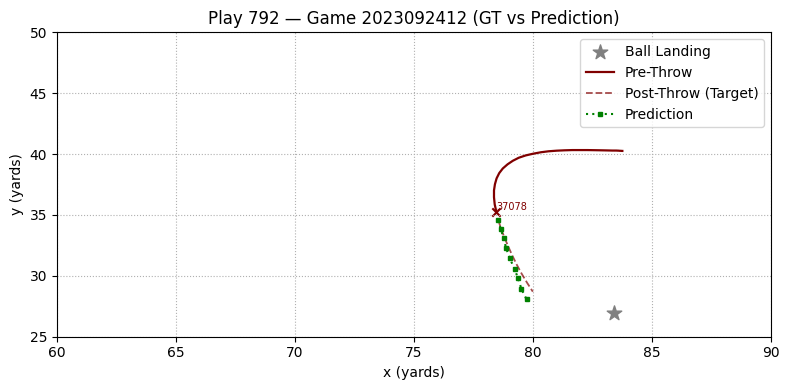

In [24]:
hist, padded_frame_mask, last_known_xy, target_xy = hist.to(DEVICE), padded_frame_mask.to(DEVICE), last_known_xy.to(DEVICE), target_xy.to(DEVICE)

preds = model(hist, padded_frame_mask, last_known_xy)
T_use = target_xy.size(1)
preds = preds[:, :T_use, :] 
print(f"META: {meta}\nPREDS: {preds}\nTARGET: {target_xy}")

GAME_ID, PLAY_ID, NFL_ID = meta['gid'][0], meta['pid'][0], meta['nfl_id'][0]

preds_dict = Evaluator.predict_play_trajectories(model, scaler, seqs=train_dataset, game_id=GAME_ID, play_id=PLAY_ID, device=DEVICE)

sequences_predict_csv = "./data/processed/train/sequences_predict.csv"
sequences_non_predict_csv = "./data/processed/train/sequences_non_predict.csv"
df_pred, df_npred = pd.read_csv(sequences_predict_csv), pd.read_csv(sequences_non_predict_csv)

Plotter.plot_single_player_with_pred(
    df_pred, df_npred,
    preds=preds,
    game_id=GAME_ID, play_id=PLAY_ID, nfl_id=NFL_ID,
    preds_dict=preds_dict,
    save_fig_path = './images/predict_plot.png'
)

In [ ]:
dd